#### 1. 生成模拟数据集。
### 通过np.squeeze()函数转换后，要显示的label变成了秩为1的数组，即（150，）
### [numpy](https://docs.scipy.org/doc/numpy/index.html)
### [matplotlib](https://matplotlib.org/api/api_overview.html)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

data = []
label = []
# 当我们设置相同的seed，每次生成的随机数相同。
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    # numpy.random.uniform(low=0.0, high=1.0, size=None)
    # Draw samples from a uniform distribution.
    # Samples are uniformly distributed over the half-open interval [low, high)
    x1 = np.random.uniform(-1,1)
    x2 = np.random.uniform(0,2)
    if x1**2 + x2**2 <= 1: # circle: o(0,0), R=1
        data.append([np.random.normal(x1, 0.1),np.random.normal(x2,0.1)])
        label.append(0) # Red
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1) # Blue
# hstack: Stack arrays in sequence horizontally (column wise).
data = np.hstack(data).reshape(-1,2)
print "data[0]: ", data[0]
print "data.len: ", len(data)
label = np.hstack(label).reshape(-1, 1)
print "label[0]: ", label[0]
print "label.len: ", len(label)
# matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
# alpha=None, linewidths=None, verts=None, edgecolors=None, *, data=None, **kwargs)
# c : color, sequence, or sequence of color, optional, default: 'b'
# cmap : Colormap, optional, default: None
# vmin, vmax : scalar, optional, default: None
plt.scatter(data[:,0], data[:,1], c=np.squeeze(label),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()

data[0]:  [0.19550081 1.65446805]
data.len:  150
label[0]:  [1]
label.len:  150


<Figure size 640x480 with 1 Axes>

#### 2. 定义一个获取权重，并自动加入正则项到损失的函数。

In [2]:
def get_weight(shape, lambda1):
    # weight = var
    # tf.random_normal: 高斯分布/正态分布
    # book P67
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # 加入到"losses"集合
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(var))
    return var

#### 3. 定义神经网络。

### MSE 定义：
$$mse(y,y^{'})=\frac{1}{n} \sum_{i=1}^n(y-y^{'})^2$$

In [3]:
# A place hold the input batches.
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
sample_size = len(data)
# 每层节点的个数
layer_dimention = [2,10,5,3,1]
n_layers = len(layer_dimention)
# input data
cur_layer = x
in_dimention = layer_dimention[0]
# 循环生成网络结构
for i in range(1, n_layers):
    # output dimention
    out_dimention = layer_dimention[i]
    weight = get_weight([in_dimention, out_dimention], 0.003) # Regular lambda:0.003
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimention]))
    # layer
    cur_layer = tf.nn.relu(tf.matmul(cur_layer, weight)+bias)
    # for iteration
    in_dimention = out_dimention
# output 
y = cur_layer
# Loss function
mse_loss = tf.reduce_sum(tf.pow((y-y_),2)) / sample_size #
tf.add_to_collection('losses', mse_loss)
# Get & add all losses.
loss = tf.add_n(tf.get_collection('losses'))

#### 4. 训练不带正则项的损失函数mse_loss。

After 0 steps, mse loss is: 229.516541
After 1000 steps, mse loss is: 0.233241
After 2000 steps, mse loss is: 0.181262
After 3000 steps, mse loss is: 0.122296
After 4000 steps, mse loss is: 0.070240
After 5000 steps, mse loss is: 0.041388
After 6000 steps, mse loss is: 0.033316
After 7000 steps, mse loss is: 0.030531
After 8000 steps, mse loss is: 0.027729
After 9000 steps, mse loss is: 0.025745
After 10000 steps, mse loss is: 0.024792
After 11000 steps, mse loss is: 0.023680
After 12000 steps, mse loss is: 0.022993
After 13000 steps, mse loss is: 0.022382
After 14000 steps, mse loss is: 0.021772
After 15000 steps, mse loss is: 0.021216
After 16000 steps, mse loss is: 0.020733
After 17000 steps, mse loss is: 0.020273
After 18000 steps, mse loss is: 0.019892
After 19000 steps, mse loss is: 0.019512
grid[0:5]: 
[[-1.2  -0.2 ]
 [-1.2  -0.19]
 [-1.2  -0.18]
 [-1.2  -0.17]
 [-1.2  -0.16]]


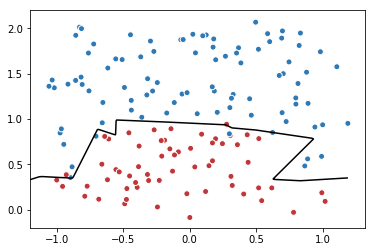

In [7]:
# 定义训练的目标函数mse_loss，训练次数及训练模型
train_opt = tf.train.AdamOptimizer(0.001).minimize(mse_loss) # !!! mse_loss
TRAIN_STEPS = 20000
with tf.Session() as sess:
    tf.global_variables_initializer().run() # init all variables.
    for i in range(TRAIN_STEPS):
        sess.run(train_opt, feed_dict={x:data, y_:label})
        # Print log
        if i%1000 == 0:
            print("After %d steps, mse loss is: %f" % (i, sess.run(mse_loss, feed_dict={x:data, y_:label})))
    
    # 画出训练后的分割曲线 
    # nd_grid instance which returns a dense multi-dimensional “meshgrid”.
    # x_axis:[-1.2,1.2],step=0.01; y_axis:[-0.2,2.2],step=0.01
    xx,yy = np.mgrid[-1.2:1.2:0.01, -0.2:2.2:0.01]
    # numpy.ravel: Return a contiguous flattened array.
    # numpy.c_: Translates slice objects to concatenation along the second axis.
    grid = np.c_[xx.ravel(), yy.ravel()] # grid:[[x0,y0],[x1,y1]]
    print "grid[0:5]: \n", grid[0:5]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)
# Plot
plt.scatter(data[:,0], data[:,1], c=np.squeeze(label), cmap="RdBu", vmin=-0.2, vmax=1.2, edgecolor="white")
# contour([X, Y,] Z, [levels], **kwargs)
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()

#### 5. 训练带正则项的损失函数loss。

After 0 steps, loss: 73.936920, l_r: 0.010000
After 1000 steps, loss: 0.088625, l_r: 0.009800
After 2000 steps, loss: 0.077418, l_r: 0.009604
After 3000 steps, loss: 0.069272, l_r: 0.009412
After 4000 steps, loss: 0.061791, l_r: 0.009224
After 5000 steps, loss: 0.055454, l_r: 0.009039
After 6000 steps, loss: 0.049594, l_r: 0.008858
After 7000 steps, loss: 0.044943, l_r: 0.008681
After 8000 steps, loss: 0.041586, l_r: 0.008508
After 9000 steps, loss: 0.039644, l_r: 0.008337
After 10000 steps, loss: 0.038739, l_r: 0.008171
After 11000 steps, loss: 0.038471, l_r: 0.008007
After 12000 steps, loss: 0.038445, l_r: 0.007847
After 13000 steps, loss: 0.038427, l_r: 0.007690
After 14000 steps, loss: 0.038445, l_r: 0.007536
After 15000 steps, loss: 0.038435, l_r: 0.007386
After 16000 steps, loss: 0.038431, l_r: 0.007238
After 17000 steps, loss: 0.038431, l_r: 0.007093
After 18000 steps, loss: 0.038449, l_r: 0.006951
After 19000 steps, loss: 0.038436, l_r: 0.006812
After 20000 steps, loss: 0.03845

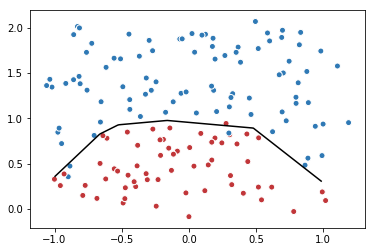

In [19]:
# 指数衰减的学习率
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, 0.98, staircase=True)
# 定义训练的目标函数loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step) # All losses.
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x:data, y_:label})
        if i % 1000 == 0:
            print("After %d steps, loss: %f, l_r: %f" % (i, sess.run(loss, feed_dict={x:data, y_:label}), 
                                                         sess.run(learning_rate)))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=np.squeeze(label),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
# contour([X, Y,] Z, [levels], **kwargs)
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()